## Problem 3 (Piecewise Linear Regression)


### 1. Load libraries

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib.pyplot as plt

### 2. Prepare Data
- Load data
- Split data to training and test data

In [8]:
# 1. Temperature
#df = pd.read_csv('./tsp_dataset/monthly-mean-temp.csv')
#df.head()

# 2. Airplane
df = pd.read_csv('./tsp_dataset/airline-passengers.csv')
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
dataset = 'Airline'
x_label = 'Month'
y_label = 'Passengers'
df.head()

# # 3. Female birth
#df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv')
#df.head()
#dataset = 'Daily total female birth'
#x_label = 'Date'
#y_label = 'Births'


# # 4. Car sales
# df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv')
# df.head()
# dataset = 'monthly-car-sales'
# x_label = 'Month'
# y_label = 'Sales'


# 5. Shampoo sales
# df = pd.read_csv('./tsp_dataset/shampoo.csv')
#df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv')
#df.head()
#dataset = 'shampoo'
#x_label = 'Month'
#y_label = 'Sales'


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
## Make data for training
def make_batch(input_data, sl):
    train_x = []
    train_y = []
    L = len(input_data)
    for i in range(L-sl):
        train_seq = input_data[i:i+sl]
        train_label = input_data[i+sl:i+sl+1]
        train_x.append(train_seq)
        train_y.append(train_label)
    return train_x, train_y

In [10]:
sequence_length = 8 # Hyperparameter

# Make Training data & Test data (Split data 8:2)
X, Y = make_batch(df[y_label].to_numpy(), sequence_length)
train_length = int(len(Y) * 0.6) # use 80% data for training.
X_train = X[:train_length]
X_train = np.hstack((X_train,np.ones((len(X_train),1)))) #Add 1 for intercept
Y_train = Y[:train_length]

X_test = X[train_length:]
X_test = np.hstack((X_test,np.ones((len(X_test),1)))) #Add 1 for intercept
Y_test = Y[train_length:]
X_train

array([[112., 118., 132., 129., 121., 135., 148., 148.,   1.],
       [118., 132., 129., 121., 135., 148., 148., 136.,   1.],
       [132., 129., 121., 135., 148., 148., 136., 119.,   1.],
       [129., 121., 135., 148., 148., 136., 119., 104.,   1.],
       [121., 135., 148., 148., 136., 119., 104., 118.,   1.],
       [135., 148., 148., 136., 119., 104., 118., 115.,   1.],
       [148., 148., 136., 119., 104., 118., 115., 126.,   1.],
       [148., 136., 119., 104., 118., 115., 126., 141.,   1.],
       [136., 119., 104., 118., 115., 126., 141., 135.,   1.],
       [119., 104., 118., 115., 126., 141., 135., 125.,   1.],
       [104., 118., 115., 126., 141., 135., 125., 149.,   1.],
       [118., 115., 126., 141., 135., 125., 149., 170.,   1.],
       [115., 126., 141., 135., 125., 149., 170., 170.,   1.],
       [126., 141., 135., 125., 149., 170., 170., 158.,   1.],
       [141., 135., 125., 149., 170., 170., 158., 133.,   1.],
       [135., 125., 149., 170., 170., 158., 133., 114.,

### 4. Piecewise Regression on Radial Basis
- 앞에서 구했던 RBF regression 함수를 사용하여 Piecewise Regression을 수행합니다.

In [11]:
def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


class PiecewiseRegression:

    def __init__(self, X, y, tX, ty, k, plotKmeans, usePiewise):
        # Train set
        self.X = X
        self.y = y

        # Test set
        self.tX = tX
        self.ty = ty

        # Number of clusters
        self.k = k
        
        # Determine whether to draw Kmeans or not
        self.plotKmeans = plotKmeans
        
        # Determine whether to use Piecewise or not
        self.usePiewise = usePiewise


    ###########################################################
    # Define rbf function.
    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return np.exp(-distance / s ** 2)
    ###########################################################

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)
    
    ###########################################################
    # Make Psi_X to perform Regression 
    def PSI_X(self, x, rbf_x, k):
        Psi_X = []
        for n in range(len(x)): # N iter
            psi_x = []
            for c in range(k): # c iter (# number of clusters)
                psi_x.extend(rbf_x[n][c]*x[n])

            Psi_X.append(psi_x)
        return np.array(Psi_X)
    ###########################################################

    
    def fit(self):

        
        ####### perform K-means and get centroids #########################
        kmeans = KMeans(n_clusters=self.k, random_state=0).fit(self.X)
        self.centroids = kmeans.cluster_centers_
        #####################################################################
        
        # Plot centroids
        if self.plotKmeans:
            fig, axs = plt.subplots(nrows=2, ncols=1)
            axs[0].scatter(X_train[:,0], X_train[:,1])
            for i in range(len(self.centroids)):
                axs[0].scatter(self.centroids[i][0] ,self.centroids[i][1], color='red')
            axs[0].set_title('Results of K means clustering', fontsize=20)
        else: fig, axs = plt.subplots(nrows=1, ncols=1)
        
        #### Use standard deviation as square(2*k) / D (the maximum distance between any 2 centroids)
        dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
        if dMax==0: self.std_list =1
        else: self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)
        

        ######################################################################
        # Use centroid and standards to make RBF_X
        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        # Normalize
        for i in range(len(RBF_X)):
            RBF_X[i] = RBF_X[i]/sum(RBF_X[i]) # N x C
        ######################################################################
    
    
        if self.usePiewise:
            ######################################################################
            # Use defined function PSI_X to make Psi_X data
            Psi_X = self.PSI_X(self.X, RBF_X, self.k)
            ######################################################################
        else:
            Psi_X = RBF_X
        
        ######################################################################
        # Apply LSE to Psi_X for Piecewise Regression 
        # - (Method 1) You can use np.linalg.pinv as the problem 2,
        # - (Method 2) or You can use LinearRegression function 
        
        #Method 1
        #self.w = np.linalg.pinv(Psi_X.T @ Psi_X) @ Psi_X.T @ self.y 
        
        #Method 2
        # Create linear regression object
        regr = linear_model.LinearRegression()
        # Train the model using the training sets
        regr.fit(Psi_X, self.y)
        ######################################################################

        
        ######################################################################
        # Use the estimated theta calculated above, and fit the predicted y.
        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)
        
        # Normalize
        for i in range(len(RBF_list_tst)):
            RBF_list_tst[i] = RBF_list_tst[i]/sum(RBF_list_tst[i])
        
        # Make Psi_X for test data  
        if self.usePiewise:
            ######################################################################
            # Use defined function PSI_X to make Psi_X data
            Psi_tX = self.PSI_X(self.tX, RBF_list_tst, self.k)
            ######################################################################
        else:
            Psi_tX = RBF_list_tst
            
        # Predict the test values 
        #self.pred_ty = Psi_tX @ self.w (Method 1)
        self.pred_ty = regr.predict(Psi_tX) #(Method 2)
        ######################################################################
        
        
        # Plot the predicted y
        if self.plotKmeans:
            plt.rcParams["figure.figsize"] = (16, 10)
            axs[1].plot(self.pred_ty, label='predicted y')
            axs[1].plot(self.ty, label='ground-truth y')
            axs[1].legend()
            axs[1].set_xticks(np.arange(1, len(self.ty), 1))
            if self.usePiewise:
                axs[1].set_title('Piecewise Linear Regression', fontsize=20)
            else:
                axs[1].set_title('RBF basis Regression', fontsize=20)
        else: 
            plt.rcParams["figure.figsize"] = (16, 5)
            axs.plot(self.pred_ty, label='predicted y')
            axs.plot(self.ty, label='ground-truth y')
            axs.legend()
            axs.set_xticks(np.arange(1, len(self.ty), 1))
            if self.usePiewise:
                axs.set_title('Piecewise Linear Regression', fontsize=20)
            else:
                axs.set_title('RBF Basis Regression', fontsize=20)
        
        plt.show()


C:\Users\jycho\anaconda3\envs\jyc\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "


TypeError: zip argument #2 must support iteration

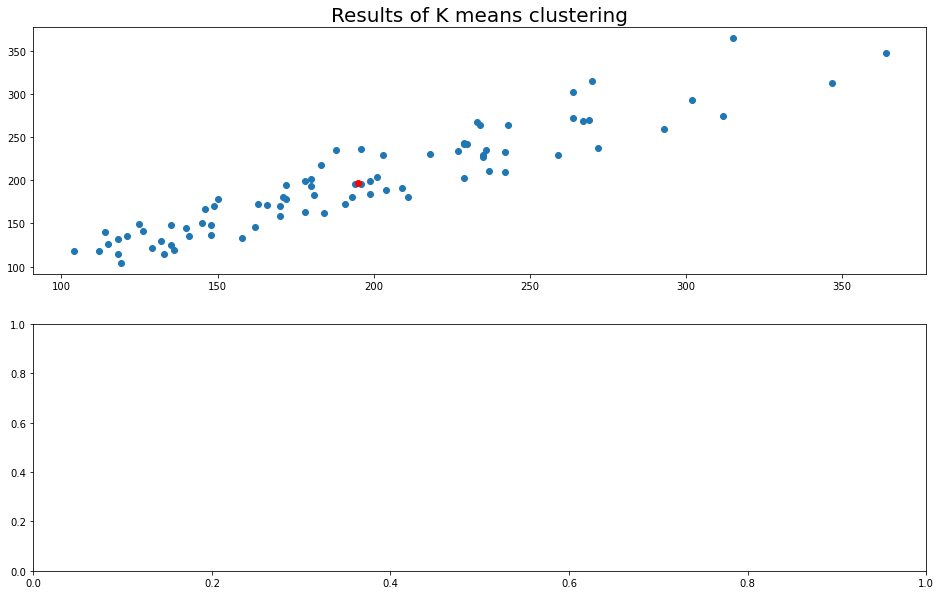

In [14]:
# Train Piecewise Linear Regressioin model and fit the test data
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 1
PR_CLASSIFIER = PiecewiseRegression(X_train, Y_train, X_test, Y_test, k=n_cluster, plotKmeans=True, usePiewise=True)
PR_CLASSIFIER.fit()

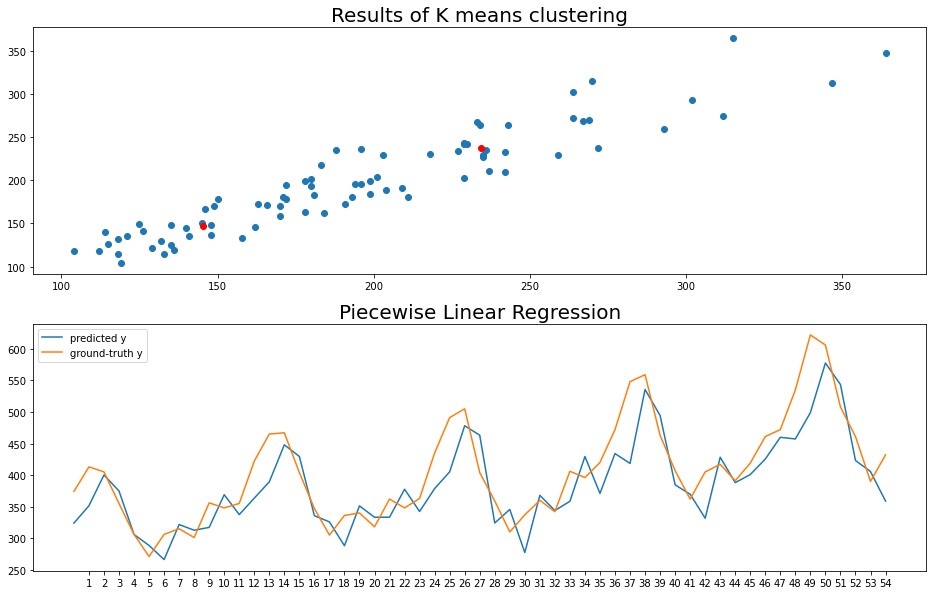

In [13]:
# Train Piecewise Linear Regressioin model and fit the test data
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 2
PR_CLASSIFIER = PiecewiseRegression(X_train, Y_train, X_test, Y_test, k=n_cluster, plotKmeans=True, usePiewise=True)
PR_CLASSIFIER.fit()

### Compare results sith just using RBF basis regression

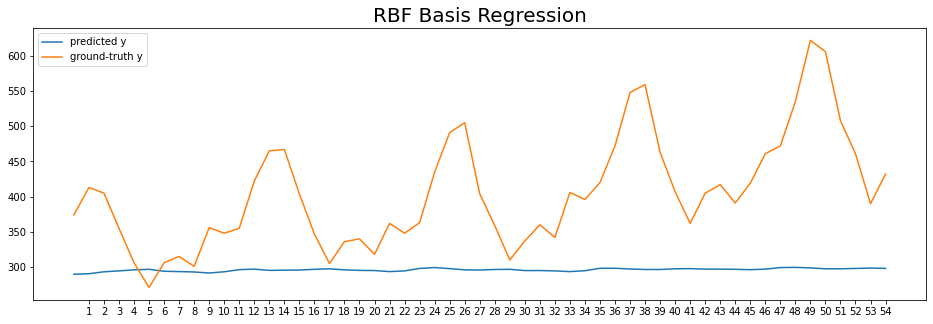

In [39]:
# Train RBF model and fit the test data
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 3
RBF_CLASSIFIER = PiecewiseRegression(X_train, Y_train, X_test, Y_test, k=n_cluster, plotKmeans=False, usePiewise=False)
RBF_CLASSIFIER.fit()

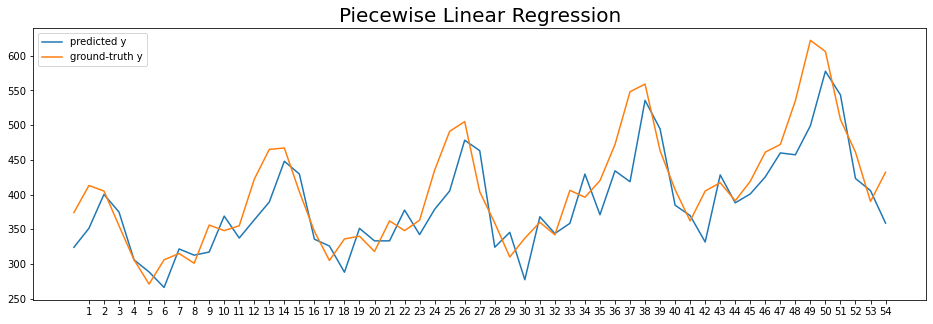

In [40]:
# Train Piecewise with RBF basis
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 2
PR_CLASSIFIER = PiecewiseRegression(X_train, Y_train, X_test, Y_test, k=n_cluster, plotKmeans=False, usePiewise=True)
PR_CLASSIFIER.fit()

### Compare results on Chaos data (Problem 2)

In [38]:
## Load data
df = pd.read_csv('tsp_dataset/chaos_data2.csv', header=0)
# Make Training data & Test data (Split data 8:2)
train_length = int(len(df) * 0.8) # use 80% data for training.
train_data2 = df[:train_length]
X_train2 = train_data2.loc[:, train_data2.columns != 'y_k'].to_numpy()
Y_train2 = train_data2.loc[:, train_data2.columns == 'y_k'].to_numpy()
test_data2 = df[train_length:]
X_test2 = test_data2.loc[:, test_data2.columns != 'y_k'].to_numpy()
Y_test2 = test_data2.loc[:, test_data2.columns == 'y_k'].to_numpy()

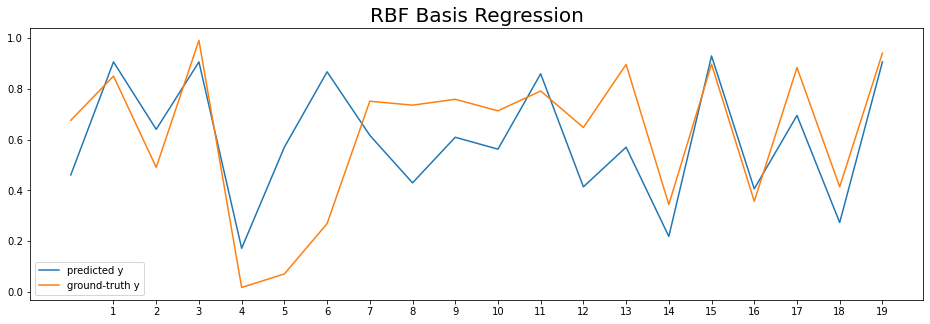

In [39]:
# Train RBF model and fit the test data
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 10
RBF_CLASSIFIER = PiecewiseRegression(X_train2, Y_train2, X_test2, Y_test2, k=n_cluster, plotKmeans=False, usePiewise=False)
RBF_CLASSIFIER.fit()

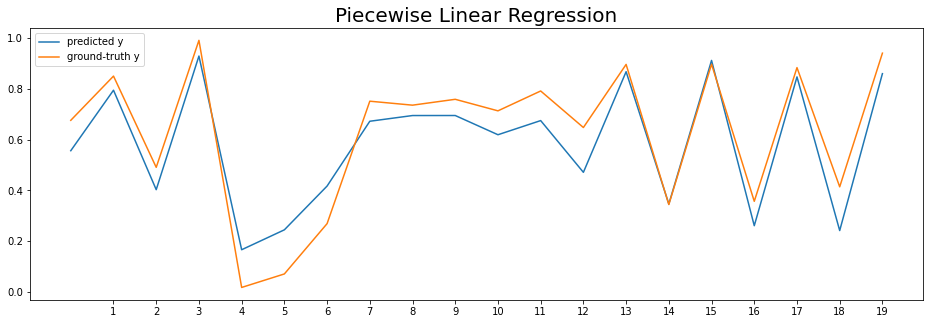

In [42]:
# Train Piecewise Linear Regressioin model and fit the test data
### Hyperparameter : n_cluster (number of clusters)
n_cluster = 10
PR_CLASSIFIER = PiecewiseRegression(X_train2, Y_train2, X_test2, Y_test2, k=n_cluster, plotKmeans=False, usePiewise=True)
PR_CLASSIFIER.fit()